# 02-peak-local-max.ipynb
This notebook is similar continues the segmentation procedure outline in `README.md`, with a different step for determing the local maxima. 
Steps performed here include:
- Load data
- Calculate local maxima for foreground seed
- Calculate local maxima of gradient for background seeds

Note: This NB uses `napari` as an image viewer. If you would rather not use `napari`, see NB 01 for a way to view images using `matplotlib.pyplot` instead.

# Import packages

In [112]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import imagecodecs  # dependency required for loading compressed tif images
import imageio as iio
import napari
import matplotlib.pyplot as plt
import numpy as np
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

# Load data

In [103]:
# open napari viewer
viewer = napari.Viewer()

In [104]:
project_dir = Path('..').resolve()
print(project_dir)

C:\Users\gusb\Research\mhe-analysis


img.shape=(1004, 924)
img.dtype=dtype('float64')


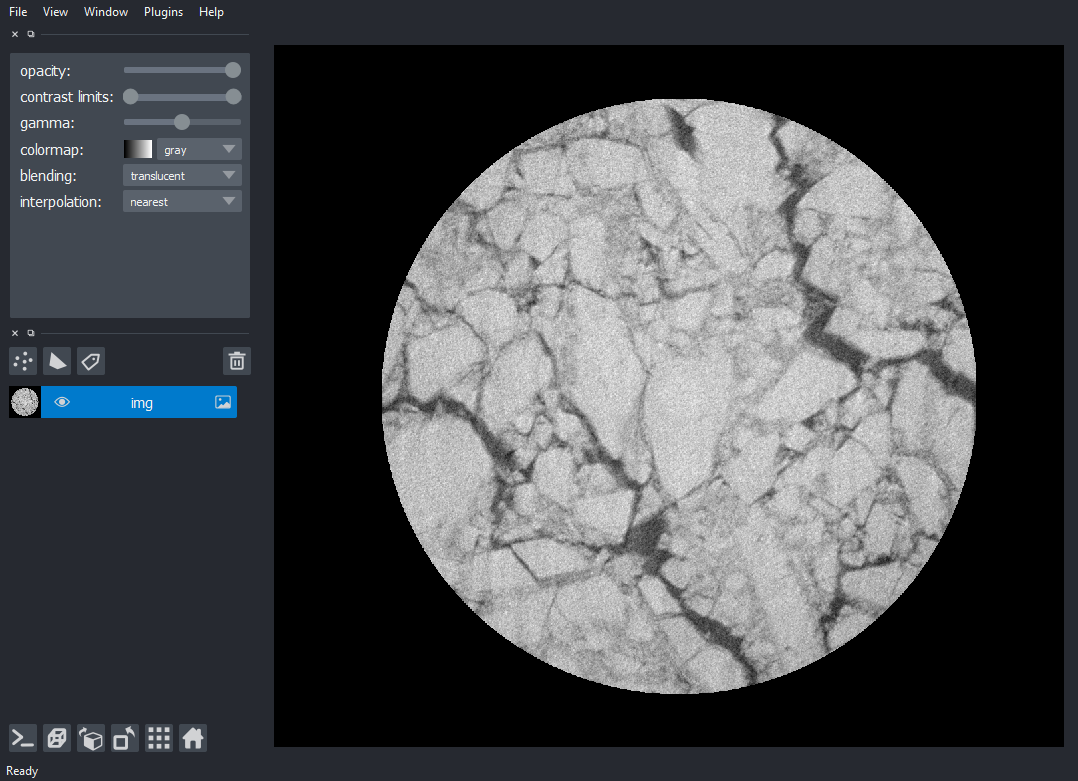

In [105]:
img_path = Path(project_dir / 'IDOX_500.tif')   
img = iio.imread(img_path)
img = util.img_as_float(img)
print(f'{img.shape=}')
print(f'{img.dtype=}')
viewer.add_image(img)
napari.utils.nbscreenshot(viewer)

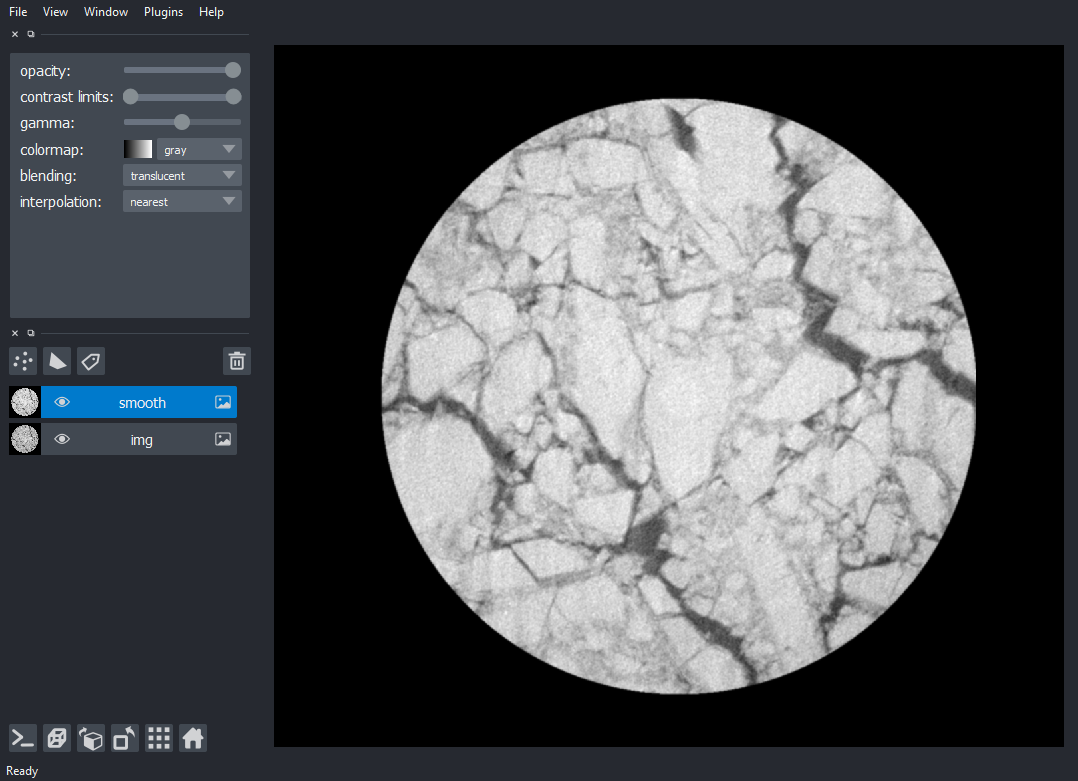

In [106]:
smooth = filters.gaussian(img)
viewer.add_image(smooth)
napari.utils.nbscreenshot(viewer)

# Calculate local maxima for foreground seeds

For some reason it didn't show up in Google searches, but I finally found an h-maxima algorithm for determining local maxima in `skimage` within the `morphology` submodule.

In [107]:
def get_h_extrema_overlay(extrema: str, img, h, fill=False, bg_img=None):
    if bg_img is None:
        bg_img = img
    if extrema == 'max':
        h_extrema = morphology.h_maxima(img, h)
    elif extrema == 'min':
        h_extrema = morphology.h_minima(img, h)
    h_extrema_label = measure.label(h_extrema)
    overlay = color.label2rgb(
        h_extrema_label, image=bg_img, alpha=1, colors=[(1, 0, 0)],
        bg_label=0, bg_color=None
    )
    return overlay

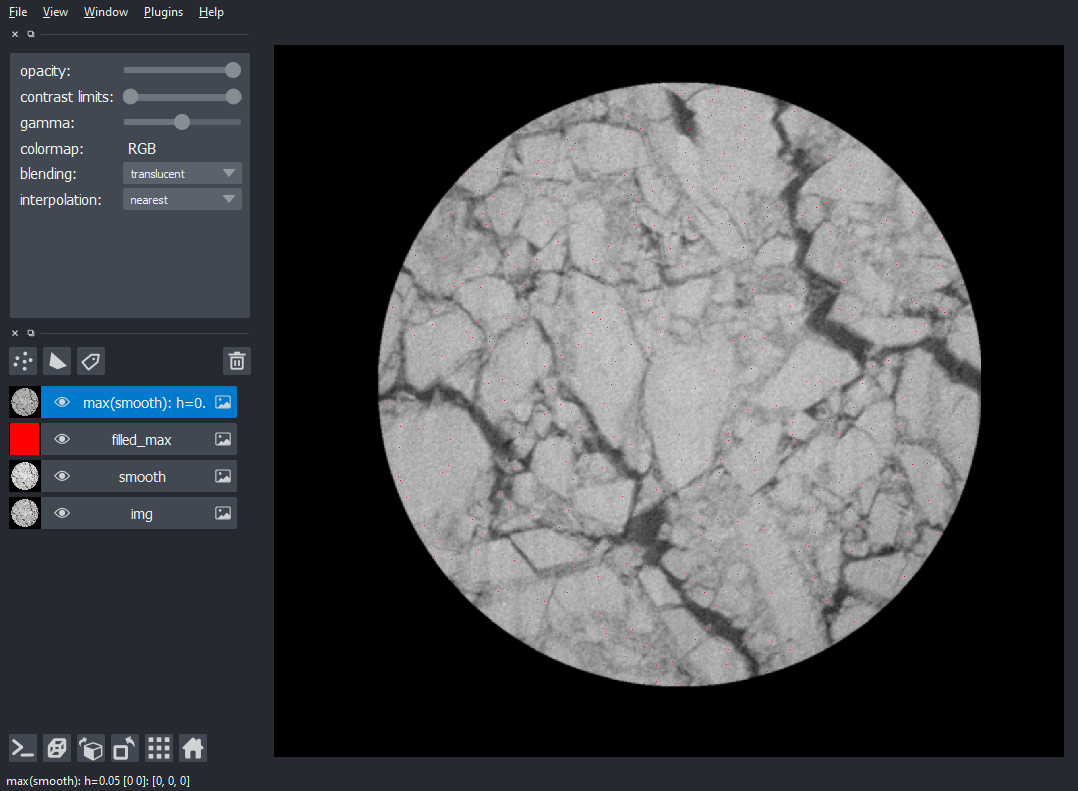

In [123]:
h = 0.05
h_max_overlay = get_h_extrema_overlay('max', smooth, h)
viewer.add_image(h_max_overlay, name=f'max(smooth): {h=}')
napari.utils.nbscreenshot(viewer)

Now that we have the h-maxima values, we can threshold the area within h to create the foreground seeds.

We need to iterate through each of the maxima and create a thresholded image that will select all the elements within the height, h.

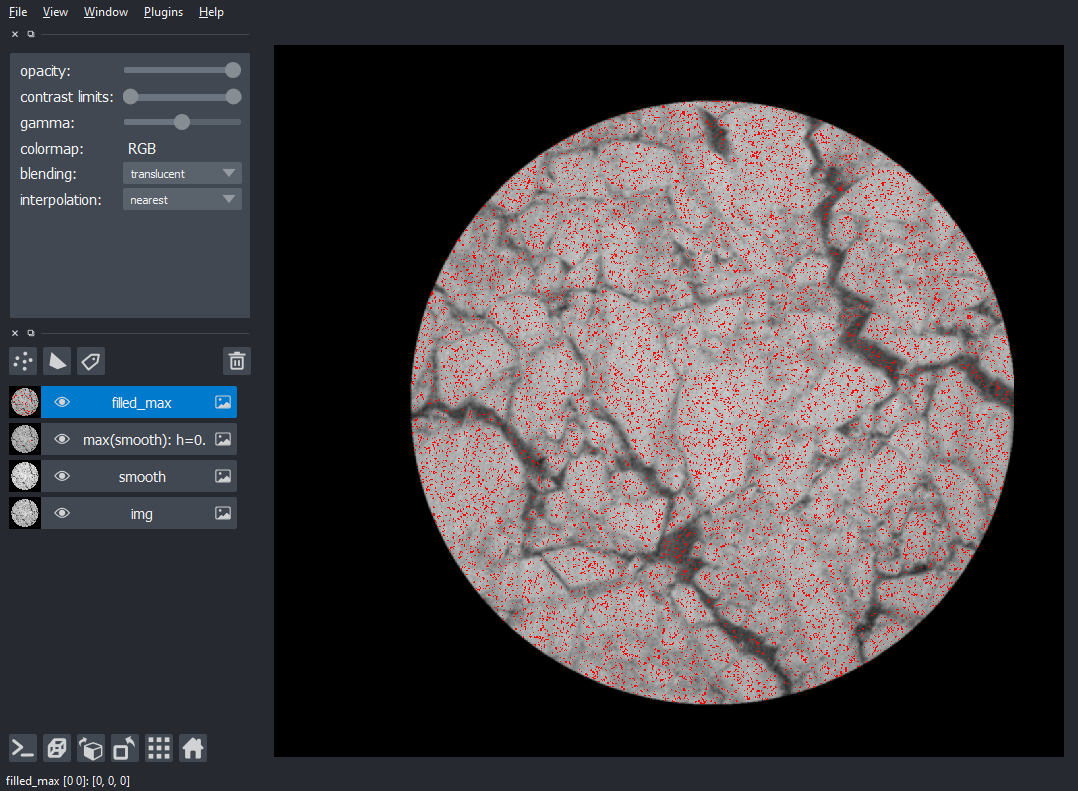

In [124]:
h = 0.05
filled_max = img.copy()
h_max = morphology.h_maxima(filled_max, h)
h_max_label = measure.label(h_max)
for region in measure.regionprops(h_max_label):
    segmentation.flood_fill(
        filled_max, tuple(region.coords[0]), region.label, tolerance=h,
        in_place=True
    )
overlay = color.label2rgb(
    filled_max, image=smooth, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(overlay, name=f'filled_max')
napari.utils.nbscreenshot(viewer)

In [109]:
h_max = morphology.h_maxima(img, h)
h_max_idcs = np.where(h_max == 1)
h_max_idcs

(array([ 55,  55,  55, ..., 948, 949, 949], dtype=int64),
 array([461, 476, 481, ..., 496, 475, 483], dtype=int64))

# Calculate local maxima of gradient for background seeds

## Calulcate gradient of image

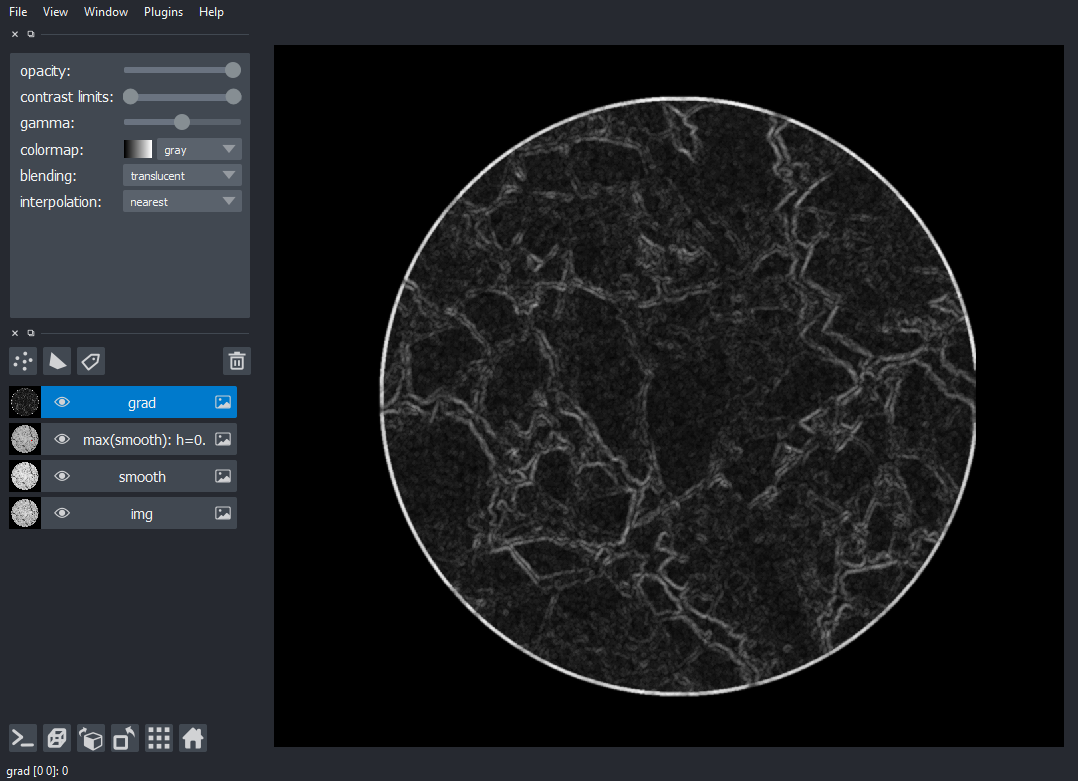

In [110]:
grad = filters.rank.gradient(util.img_as_ubyte(smooth), morphology.disk(3))
grad = util.img_as_float(grad)
viewer.add_image(grad)
napari.utils.nbscreenshot(viewer)

## Calculate h-minima of gradient

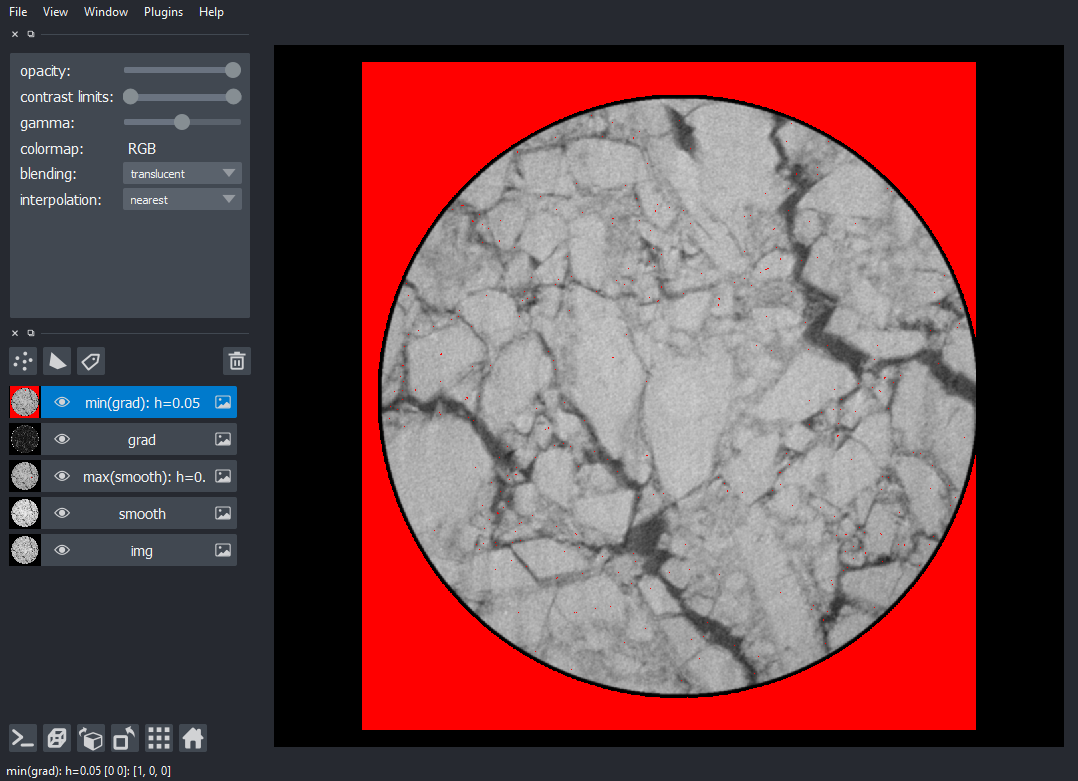

In [111]:
h = 0.05
grad_h_min_overlay = get_h_extrema_overlay('min', grad, h, bg_img=smooth)
viewer.add_image(grad_h_min_overlay, name=f'min(grad): {h=}')
napari.utils.nbscreenshot(viewer)